In [6]:
%matplotlib qt

from glob import glob
import matplotlib.pyplot as plt
import nibabel as nib

for path in glob('2022-10-18_14H59\gt_niftis\*.gz'):
    data = nib.load(path)
    arr = data.get_fdata()
    slice_nb = arr.shape[2] // 2

    fig, ax = plt.subplots(1, 1)
    ax.imshow(arr[:, :, slice_nb], cmap='gray')
    plt.waitforbuttonpress()
    plt.close(fig)

KeyboardInterrupt: 

In [10]:
%matplotlib qt

from glob import glob
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

count = []
for path in glob(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task026_MMs\labelsTr\*.gz'):
    data = nib.load(path)
    arr = data.get_fdata()
    #print(arr.shape)
    count.append(arr.shape[2])
out = np.array(count)
print(out.min())
print(out.max())
print(out.sum())

    #fig, ax = plt.subplots(1, 1)
    #ax.imshow(arr[0, 5, :, :], cmap='gray')
    #plt.waitforbuttonpress()
    #plt.close(fig)

5
20
7334


In [8]:
%matplotlib qt

from skimage.registration import optical_flow_tvl1
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

data = np.load(r'out\nnUNet_raw_data_base\nnUNet_cropped_data\Task027_ACDC\patient001_frame01.npz')
#arr = data.get_fdata()
arr = data['data']
print(arr.shape)

fig, ax = plt.subplots(1, 1)
ax.imshow(arr[0, 2, :, :], cmap='gray')
plt.axis('off')
plt.waitforbuttonpress()
plt.close(fig)

(2, 10, 256, 216)


KeyboardInterrupt: 

In [8]:
import json
import numpy as np

mean_list = []
with open(r'out\nnUNet_trained_models\nnUNet\2d\Task027_ACDC\nnMTLTrainerV2__custom_experiment_planner\temp_allClasses\summary.json') as f:
    data = json.load(f)
    for d in data['results']['all']:
        m = (d['1']['Dice'] + d['2']['Dice'] + d['3']['Dice']) / 3
        mean_list.append(m)
mean_list = np.array(mean_list)
print(mean_list.mean())
print(mean_list.std())


0.9239589558270734
0.032820337994105234


In [3]:
from lib.training_utils import read_config
from run.default_configuration import get_default_configuration

config = read_config('adversarial_acdc_middle.yaml', True)

plans_file, output_folder_name, dataset_directory, batch_dice, stage, \
        trainer_class = get_default_configuration('2d', 'Task027_ACDC', 'nnMTLTrainerV2', config, 'custom_experiment_planner')

output_folder_name = '2022-10-07_16H20'
trainer = trainer_class(plans_file, 0, output_folder=output_folder_name, dataset_directory=dataset_directory,
                            batch_dice=batch_dice, stage=stage, unpack_data=True, middle=True,
                            deterministic=True,
                            fp16=True)

trainer.load_final_checkpoint(train=False)

trainer.network.eval()
percents = [0.08333, 0.056666, 0.1176, 0.1667, 0.1333, 0.1765, 0.1875, 0.2, 0.1538, 0.1429, 0.125, 0.06667, 0.07143]

for idx, percent in enumerate(percents):
    trainer.network.percent = percent

    folder = "inference_testings/validation_raw_" + str(percent)

    trainer.validate(save_softmax=False, validation_folder_name=folder,
                            run_postprocessing_on_folds=True,
                            overwrite=False)

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnMTLTrainerV2.nnMTLTrainerV2'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'MRI'}
use_mask_for_norm OrderedDict([(0, False)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 2, 'num_pool_per_axis': [3, 3], 'patch_size': array([224, 224]), 'median_patient_size_in_voxels': array([  9, 249, 219]), 'current_spacing': array([10.        ,  1.48438001,  1.48438001]), 'original_spacing': array([10.        ,  1.48438001,  1.48438001]), 'pool_op_kernel_sizes': [[2, 2], [2, 2], [2, 2]], 'conv_kernel_sizes': [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3]], 'do_dummy_2D_data_aug': False}

I am using stage 0 from these plans
I am using batch dice + CE loss

I am using data from th

In [1]:
from lib.training_utils import read_config
from run.default_configuration import get_default_configuration

config = read_config('adversarial_acdc.yaml', False)

plans_file, output_folder_name, dataset_directory, batch_dice, stage, \
        trainer_class = get_default_configuration('2d', 'Task026_MMs', 'nnMTLTrainerV2', config, 'custom_experiment_planner')

output_folder_name = '2022-10-18_14H59'
trainer = trainer_class(plans_file, 0, output_folder=output_folder_name, dataset_directory=dataset_directory,
                            batch_dice=batch_dice, stage=stage, unpack_data=True, middle=False,
                            deterministic=True,
                            fp16=True)

trainer.load_final_checkpoint(train=False)

trainer.network.eval()

folder = "inference_testings/validation_raw_hd95"

trainer.validate(save_softmax=False, validation_folder_name=folder,
                            run_postprocessing_on_folds=True,
                            overwrite=False)

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnMTLTrainerV2.nnMTLTrainerV2'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'MRI'}
use_mask_for_norm OrderedDict([(0, False)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 6, 'num_pool_per_axis': [3, 3], 'patch_size': array([288, 288]), 'median_patient_size_in_voxels': array([ 11, 280, 303]), 'current_spacing': array([10.  ,  1.25,  1.25]), 'original_spacing': array([10.  ,  1.25,  1.25]), 'pool_op_kernel_sizes': [[2, 2], [2, 2], [2, 2]], 'conv_kernel_sizes': [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3]], 'do_dummy_2D_data_aug': False}

I am using stage 0 from these plans
I am using batch dice + CE loss

I am using data from this folder:  C:\Users\Portal\Document

In [4]:
%matplotlib qt

from skimage.registration import optical_flow_tvl1
import nibabel as nib
import matplotlib.pyplot as plt

data = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task027_ACDC\labelsTr\patient001_frame01.nii.gz')
arr = data.get_fdata()

img1 = arr[:, :, 2]
img2 = arr[:, :, 8]

out = optical_flow_tvl1(img1, img2)
print(out.shape)

fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(img1, cmap='gray')
ax[0, 1].imshow(img2, cmap='gray')
ax[1, 0].imshow(out[0], cmap='plasma')
ax[1, 1].imshow(out[1], cmap='plasma')
plt.waitforbuttonpress()
plt.close(fig)

(2, 216, 256)


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt

a = np.array([[0., 1, 2], [0., 1, 2], [0., 1, 2]])

cmap = cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
print(len(cmaplist))

cmaplist[0] = (0, 0, 0, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, 4, 5)
print(bounds)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
print(norm(a))
a_new = cmap(norm(a))
print(norm)
print(a_new)

plt.imshow(a_new)

In [1]:
%matplotlib qt

import nibabel as nib
import matplotlib.pyplot as plt
import torch
from skimage.transform import resize

data = nib.load('out\\nnUNet_raw_data_base\\nnUNet_raw_data\\Task027_ACDC\\imagesTr\\patient001_frame01_0000.nii.gz')
gata_gt = nib.load('out\\nnUNet_raw_data_base\\nnUNet_raw_data\\Task027_ACDC\\labelsTr\\patient001_frame01.nii.gz')
arr = data.get_fdata()
arr_gt = gata_gt.get_fdata()
print(arr.shape)
print(arr_gt.shape)

out = resize(arr_gt, (216, 256, 15), order=0)

arr = torch.from_numpy(arr)
arr_gt = torch.from_numpy(arr_gt)

f = torch.fft.fft2(arr[:, :, 1])
f_gt = torch.fft.fft2(arr_gt[:, :, 1])

fig, ax = plt.subplots(3, 2)
ax[0, 0].imshow(arr[:, :, 1], cmap='gray')
ax[0, 1].imshow(arr_gt[:, :, 1], cmap='gray')
ax[1, 0].imshow(torch.log(torch.fft.fftshift(f.abs())), cmap='gray')
ax[1, 1].imshow(torch.log(torch.fft.fftshift(f_gt.abs())), cmap='gray')
ax[2, 0].imshow(torch.fft.fftshift(f.angle()), cmap='gray')
ax[2, 1].imshow(torch.fft.fftshift(f_gt.angle()), cmap='gray')
plt.show()

(216, 256, 10)
(216, 256, 10)


In [9]:
%matplotlib qt

import nibabel as nib
import matplotlib.pyplot as plt
import torch
from skimage.transform import resize
import numpy as np

data = nib.load('out\\nnUNet_raw_data_base\\nnUNet_raw_data\\Task027_ACDC\\imagesTr\\patient001_frame01_0000.nii.gz')
gata_gt = nib.load('out\\nnUNet_raw_data_base\\nnUNet_raw_data\\Task027_ACDC\\labelsTr\\patient001_frame01.nii.gz')
arr = data.get_fdata()
arr_gt = gata_gt.get_fdata()
print(arr.shape)
print(arr_gt.shape)

nb = 15
out = resize(arr_gt, (216, 256, nb), order=0, anti_aliasing=False)

fig, ax = plt.subplots(1, nb)
for i in range(nb):
    for j in range(arr_gt.shape[2]):
        print(np.all(arr_gt[:, :, j] == out[:, :, i]))
    print('***************************')
    ax[i].imshow(out[:, :, i], cmap='gray')

(216, 256, 10)
(216, 256, 10)
True
False
False
False
False
False
False
False
False
False
***************************
False
True
False
False
False
False
False
False
False
False
***************************
False
True
False
False
False
False
False
False
False
False
***************************
False
False
True
False
False
False
False
False
False
False
***************************
False
False
False
True
False
False
False
False
False
False
***************************
False
False
False
True
False
False
False
False
False
False
***************************
False
False
False
False
True
False
False
False
False
False
***************************
False
False
False
False
False
True
False
False
False
False
***************************
False
False
False
False
False
True
False
False
False
False
***************************
False
False
False
False
False
False
True
False
False
False
***************************
False
False
False
False
False
False
False
True
False
False
***************************
False
False
F

In [ ]:
%matplotlib qt

import nibabel as nib
import matplotlib.pyplot as plt
import torch

data = nib.load('out\\nnUNet_raw_data_base\\nnUNet_raw_data\\Task027_ACDC\\imagesTr\\patient001_frame01_0000.nii.gz')
gata_gt = nib.load('out\\nnUNet_raw_data_base\\nnUNet_raw_data\\Task027_ACDC\\labelsTr\\patient001_frame01.nii.gz')
arr = data.get_fdata()
arr_gt = gata_gt.get_fdata()
print(arr.shape)
print(arr_gt.shape)

arr = torch.from_numpy(arr)
arr_gt = torch.from_numpy(arr_gt)

f = torch.fft.fftshift(torch.fft.fft2(arr[:, :, 1]))
f_gt = torch.fft.fftshift(torch.fft.fft2(arr_gt[:, :, 1]))

cy = f.shape[0] / 2
cx = f.shape[1] / 2

f[int(cy - (cy * 0.5)):int(cy + (cy * 0.5)), int(cx - (cx * 0.5)):int(cx + (cx * 0.5))] = 0
f_gt[int(cy - (cy * 0.5)):int(cy + (cy * 0.5)), int(cx - (cx * 0.5)):int(cx + (cx * 0.5))] = 0

f = torch.fft.ifftshift(f)
f_gt = torch.fft.ifftshift(f_gt)

f_after = torch.fft.ifft2(f)
f_gt_after = torch.fft.ifft2(f_gt)

fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(arr[:, :, 1], cmap='gray')
ax[0, 1].imshow(arr_gt[:, :, 1], cmap='gray')
ax[1, 0].imshow(f_after.real, cmap='gray')
ax[1, 1].imshow(f_gt_after.real, cmap='gray')
plt.show()

In [28]:
from pathlib import Path
import shutil
from glob import glob
import os
import numpy as np
from tqdm import tqdm
import nibabel as nib

def get_slice_numbers(path_list):
    slice_number_list = []
    for path in path_list:
        slice_nb = path.split('Slice')[-1].split('_')[1]
        slice_number_list.append(slice_nb)
    return list(set(slice_number_list))

def delete_if_exist(folder_name):
    dirpath = Path(folder_name)
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)

new_folder_name = 'custom_lib'

delete_if_exist(new_folder_name)

Path(new_folder_name).mkdir(parents=True, exist_ok=True)

for i, patient in enumerate(tqdm(glob('data_ok/*/*'))):
    patient_string = ('patient' + str(i + 1).zfill(3))
    patient_folder_name = os.path.join(new_folder_name, patient_string)
    delete_if_exist(patient_folder_name)
    Path(patient_folder_name).mkdir(parents=True, exist_ok=True)
    all_patient_files = glob(os.path.join(patient, '*'))
    slice_nb_list = get_slice_numbers(all_patient_files)
    for slice_nb in slice_nb_list:
        gt_list = []
        image_list = []
        for patient_file in all_patient_files:
            if slice_nb not in patient_file:
                continue
            else:
                data = np.load(patient_file)
                image_list.append(data['arr_0'])
                gt_list.append(data['arr_1'])
        image_list = np.stack(image_list, axis=2)
        gt_list = np.stack(gt_list, axis=2)
        nib.save(nib.Nifti1Image(image_list, affine=np.eye(4)), os.path.join(patient_folder_name, patient_string + '_frame' + slice_nb + '.nii.gz'))  
        nib.save(nib.Nifti1Image(gt_list, affine=np.eye(4)), os.path.join(patient_folder_name, patient_string + '_frame' + slice_nb + '_gt.nii.gz'))  


 21%|██        | 43/206 [00:33<02:05,  1.30it/s]


KeyboardInterrupt: 

In [26]:
import numpy as np
from glob import glob
from tqdm import tqdm

shape_list = []
name_list = []
for path in tqdm(glob(r'out\nnUNet_preprocessed\Task028_Lib\custom_experiment_planner_stage0/*.npz')):
    data = np.load(path)
    shape_list.append(data['data'].shape[1])
    name_list.append(path)
shape_list = np.array(shape_list)
name_list = np.array(name_list)
idx = np.argmax(shape_list)
print(shape_list[idx])
print(name_list[idx])
print(shape_list.mean())

100%|██████████| 625/625 [00:31<00:00, 19.87it/s]

80
out\nnUNet_preprocessed\Task028_Lib\custom_experiment_planner_stage0\patient147_slice05.npz
35.1216


In [35]:
%matplotlib qt
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

data = nib.load('patient177_slice14.nii.gz')
arr = data.get_fdata()
print(arr.shape)

data2 = nib.load('gt_lib\patient177_slice14.nii.gz')
arr2 = data2.get_fdata()
print(arr2.shape)

data3 = nib.load('patient177_slice14_0000.nii.gz')
arr3 = data3.get_fdata()
print(arr3.shape)

fig, ax = plt.subplots(1, 3)
ax[0].imshow(arr[:, :, arr.shape[-1] // 2], cmap='gray')
ax[1].imshow(arr2[:, :, arr2.shape[-1] // 2], cmap='gray')
ax[2].imshow(arr3[:, :, arr3.shape[-1] // 2], cmap='gray')

(512, 512, 50)
(512, 512, 50)
(512, 512, 50)


In [37]:
from glob import glob
x_list = []
y_list = []
z_list = []
for path in glob(r'ACDC_training/**/*4d*.gz', recursive=True):
    data = nib.load(path)
    zoom = data.header.get_zooms()
    x_list.append(zoom[0])
    y_list.append(zoom[1])
    z_list.append(zoom[2])

x_list = np.array(x_list)
y_list = np.array(y_list)
z_list = np.array(z_list)

print(x_list.min())
print(x_list.max())
print(y_list.min())
print(y_list.max())
print(z_list.min())
print(z_list.max())

0.703125
1.91964
0.703125
1.91964
5.0
10.0


In [74]:
from monai.transforms import LabelToContour
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

data3 = nib.load('patient177_slice14_0000.nii.gz')
arr3 = data3.get_fdata()
arr3 = np.transpose(arr3, (2, 0, 1))
out_arr = []
for i in range(len(arr3)):
    out = cv.normalize(arr3[i], None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX).astype(np.uint8)
    out = cv.cvtColor(out, cv.COLOR_GRAY2RGB)
    out_arr.append(out)
out_arr = np.stack(out_arr, axis=0)

label_to_contour_obj = LabelToContour()
data = nib.load('patient177_slice14.nii.gz')
arr = data.get_fdata()
arr = np.transpose(arr, (2, 0, 1))

contour_list = []
for i in range(len(arr)):
    for j in range(1, 4):
        seg = (arr[i] == j).astype(np.uint8)
        contours, hierarchy = cv.findContours(seg, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        color = [0, 0, 0]
        color[j - 1] = 255
        cv.drawContours(out_arr[i], contours, -1, color, 1)

fig, ax = plt.subplots(1, 1)
ax.imshow(out_arr[20, :, :], cmap='gray')

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [31]:
data = np.load(r'out\nnUNet_preprocessed\Task028_Lib\custom_experiment_planner_stage0\patient158_slice05.npz')
print(data['data'].shape)

(2, 50, 286, 225)


In [30]:
import nibabel as nib

data = nib.load(r'custom_lib_t\patient158\patient158_slice05.nii.gz')
print(data.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 512 512  50   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.     0.7617 0.7617 0.388  1.     1.     1.     1.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : [1. 0. 

custom_lib_t\patient158\patient158_slice05.nii.gz
custom_lib_t\patient158\patient158_slice07.nii.gz
custom_lib_t\patient158\patient158_slice14.nii.gz


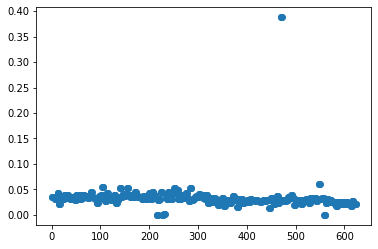

In [29]:
import pickle
from glob import glob
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

res_t_list = []
for path in glob(r'custom_lib_t\**\*.gz', recursive=True):
    if '_gt.' in path:
        continue
    data = nib.load(path)
    p = data.header['pixdim'][3]
    res_t_list.append(p)
    if p > 0.3:
        print(path)

x = np.arange(len(res_t_list))
plt.scatter(x=x, y=res_t_list)

In [9]:
from glob import glob

l = glob(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task028_Lib\imagesTr\*.gz', recursive=True)
print(len(l))

625


In [3]:
import pickle as pkl

with open(r'out\nnUNet_preprocessed\Task028_Lib\splits_final.pkl', 'rb') as f:
    print(pkl.load(f))
print('**********************************************************************************************************************************************')
with open(r'splits_final.pkl', 'rb') as f:
    print(pkl.load(f))

[OrderedDict([('train', array(['patient001_slice05', 'patient001_slice07', 'patient001_slice10',
       'patient002_slice05', 'patient002_slice07', 'patient002_slice09',
       'patient003_slice06', 'patient003_slice08', 'patient003_slice11',
       'patient004_slice08', 'patient004_slice09', 'patient004_slice11',
       'patient005_slice08', 'patient005_slice09', 'patient005_slice10',
       'patient006_slice08', 'patient006_slice09', 'patient006_slice11',
       'patient007_slice06', 'patient007_slice07', 'patient007_slice10',
       'patient008_slice06', 'patient008_slice07', 'patient008_slice08',
       'patient009_slice05', 'patient009_slice06', 'patient009_slice09',
       'patient010_slice08', 'patient010_slice09', 'patient010_slice11',
       'patient011_slice07', 'patient011_slice09', 'patient011_slice11',
       'patient012_slice07', 'patient012_slice09', 'patient012_slice10',
       'patient013_slice08', 'patient013_slice10', 'patient013_slice12',
       'patient014_slice07'

In [2]:
import pickle as pkl

with open(r"out\nnUNet_preprocessed\Task028_Lib\splits_final.pkl", 'rb') as fd:
    loaded = pkl.load(fd)
    print(loaded)

[OrderedDict([('train', array(['patient001_slice04', 'patient001_slice05', 'patient001_slice09',
       'patient002_slice04', 'patient002_slice05', 'patient002_slice09',
       'patient003_slice04', 'patient003_slice05', 'patient003_slice07',
       'patient004_slice05', 'patient004_slice06', 'patient004_slice07',
       'patient005_slice03', 'patient005_slice04', 'patient005_slice06',
       'patient006_slice05', 'patient006_slice06', 'patient006_slice08',
       'patient007_slice06', 'patient007_slice09', 'patient008_slice05',
       'patient008_slice07', 'patient008_slice09', 'patient009_slice04',
       'patient009_slice05', 'patient009_slice08', 'patient010_slice04',
       'patient010_slice05', 'patient010_slice08', 'patient011_slice04',
       'patient011_slice05', 'patient011_slice07', 'patient012_slice05',
       'patient012_slice06', 'patient012_slice08', 'patient013_slice04',
       'patient013_slice05', 'patient013_slice07', 'patient014_slice06',
       'patient014_slice07'

In [3]:
import torch

state_dict = torch.load(r'no_sfb\model_final_checkpoint.model')['state_dict']
print(state_dict.keys())

odict_keys(['encoder.layers.0.blocks.0.0.weight', 'encoder.layers.0.blocks.0.0.bias', 'encoder.layers.0.blocks.0.1.weight', 'encoder.layers.0.blocks.0.1.bias', 'encoder.layers.0.blocks.0.1.running_mean', 'encoder.layers.0.blocks.0.1.running_var', 'encoder.layers.0.blocks.0.1.num_batches_tracked', 'encoder.layers.0.blocks.0.3.weight', 'encoder.layers.0.blocks.0.3.bias', 'encoder.layers.0.blocks.0.4.weight', 'encoder.layers.0.blocks.0.4.bias', 'encoder.layers.0.blocks.0.4.running_mean', 'encoder.layers.0.blocks.0.4.running_var', 'encoder.layers.0.blocks.0.4.num_batches_tracked', 'encoder.layers.0.blocks.1.0.weight', 'encoder.layers.0.blocks.1.0.bias', 'encoder.layers.0.blocks.1.1.weight', 'encoder.layers.0.blocks.1.1.bias', 'encoder.layers.0.blocks.1.1.running_mean', 'encoder.layers.0.blocks.1.1.running_var', 'encoder.layers.0.blocks.1.1.num_batches_tracked', 'encoder.layers.0.blocks.1.3.weight', 'encoder.layers.0.blocks.1.3.bias', 'encoder.layers.0.blocks.1.4.weight', 'encoder.layers.0.

In [4]:
from numpy.random import RandomState

prng1 = RandomState(1234567890)
print(prng1.uniform(0, 1))
print(prng1.uniform(0, 1))
prng2 = RandomState(1234567890)
print(prng2.uniform(0, 1))
print(prng2.uniform(0, 1))

0.61879477158568
0.5916236277597466
0.61879477158568
0.5916236277597466


In [33]:
import numpy as np

video_length = 5
s = 1
voulume_length = 15

start = s - (video_length // 2)
stop = start + video_length
assert (start >= 0 or stop <= voulume_length)
if start < 0:
    stop += abs(start)
    start = 0
if stop > voulume_length:
    start -= stop - voulume_length
    stop = voulume_length
indices = np.arange(start=start, stop=stop)
assert len(indices) == video_length
idx = np.where(indices == s)[0]
print(indices)
print(idx)

[0 1 2 3 4]
[1]


In [73]:
volume_length = 7
video_length = 2
s = 0


values = np.arange(volume_length)
step = video_length // 2
start = min(max(s - step, 0), volume_length - video_length)
indices = values[start:start + video_length]
eval_idx = int(np.where(indices == s)[0])
print(indices)
print(eval_idx)

[0 1]
0


In [21]:
%matplotlib qt

from nnunet.postprocessing.connected_components import remove_all_but_the_largest_connected_component
import numpy as np
import matplotlib.pyplot as plt

data = np.load(r'out\nnUNet_preprocessed\Task027_ACDC\custom_experiment_planner_stage0\patient001_frame01.npy')
print(data.shape)
arr = data[1, 5][None, None, :, :]
arr[:, :, 50:100, 50:60] = 2
fig, ax = plt.subplots(1, 2)
ax[0].imshow(arr[0, 0], cmap='gray')
out = remove_all_but_the_largest_connected_component(arr, for_which_classes=[2], volume_per_voxel=1)

print(out[1])

ax[1].imshow(out[0][0, 0], cmap='gray')


(2, 10, 269, 227)
{2: 500}


In [19]:
import torch
t = torch.tensor([0, 1, 2, 3, 4, 5, 6]).reshape(1, 1, -1).float()
print(torch.nn.functional.interpolate(t, size=9, mode='nearest'))
print(torch.nn.functional.interpolate(t, size=9, mode='linear', align_corners=True))
print(torch.nn.functional.interpolate(t, size=9, mode='linear'))

tensor([[[0., 0., 1., 2., 3., 3., 4., 5., 6.]]])
tensor([[[0.0000, 0.7500, 1.5000, 2.2500, 3.0000, 3.7500, 4.5000, 5.2500,
          6.0000]]])
tensor([[[0.0000, 0.6667, 1.4444, 2.2222, 3.0000, 3.7778, 4.5556, 5.3333,
          6.0000]]])


In [30]:
t = torch.full(size=(10, 2), fill_value=float('nan'), dtype=float)
indices = torch.tensor([0, 2, 3, 4, 6])
values = torch.full(size=(len(indices), 2), fill_value=10, dtype=float)
t[indices] = values
print(t)
torch.tensor_split(t, [1, 3, 4, 6], dim=0)

tensor([[10., 10.],
        [nan, nan],
        [10., 10.],
        [10., 10.],
        [10., 10.],
        [nan, nan],
        [10., 10.],
        [nan, nan],
        [nan, nan],
        [nan, nan]], dtype=torch.float64)


(tensor([[10., 10.]], dtype=torch.float64),
 tensor([[nan, nan],
         [10., 10.]], dtype=torch.float64),
 tensor([[10., 10.]], dtype=torch.float64),
 tensor([[10., 10.],
         [nan, nan]], dtype=torch.float64),
 tensor([[10., 10.],
         [nan, nan],
         [nan, nan],
         [nan, nan]], dtype=torch.float64))

In [4]:
import numpy as np
import json
import os
from tqdm import tqdm

with open('summary.json', 'r') as f:
  data = json.load(f)['results']['all']
  per_folder_results = {'RACINE': [], 'cholcoeur': [], 'desktop': []}
  for patient in tqdm(data):
    patient_1 = patient['1']['Dice']
    patient_2 = patient['2']['Dice']
    patient_3 = patient['3']['Dice']
    patient_name = patient['test'].split('/')[-1].split('.')[0].split('_')[0]

    path = os.path.join('custom_lib_t', patient_name, 'info.cfg')
    with open(path, 'r') as fd:
      folder = fd.read().splitlines()[0].split('\\')[1]
      print(folder)
    results = np.array([patient_1, patient_2, patient_3])
    print(results)
    print(patient['test'])
    per_folder_results[str(folder)].append(results)
  
out_dict = {}
for key in per_folder_results.keys():
  temp = np.stack(per_folder_results[key], axis=0)
  print(temp.shape)
  out_dict[key] = np.mean(temp, axis=0)
print(out_dict)

100%|██████████| 122/122 [00:00<00:00, 2772.81it/s]

RACINE
[0.95227263 0.90302712 0.96211271]
out/nnUNet_trained_models/nnUNet/2d/Task028_Lib/nnMTLTrainerV2__custom_experiment_planner/fold_0/2022-11-25_18H08/validation_raw/patient002_slice05.nii.gz
RACINE
[0.95491406 0.89892595 0.97068756]
out/nnUNet_trained_models/nnUNet/2d/Task028_Lib/nnMTLTrainerV2__custom_experiment_planner/fold_0/2022-11-25_18H08/validation_raw/patient002_slice07.nii.gz
RACINE
[0.90854757 0.88168826 0.95683892]
out/nnUNet_trained_models/nnUNet/2d/Task028_Lib/nnMTLTrainerV2__custom_experiment_planner/fold_0/2022-11-25_18H08/validation_raw/patient002_slice09.nii.gz
RACINE
[0.94556716 0.94652282 0.96597868]
out/nnUNet_trained_models/nnUNet/2d/Task028_Lib/nnMTLTrainerV2__custom_experiment_planner/fold_0/2022-11-25_18H08/validation_raw/patient003_slice06.nii.gz
RACINE
[0.93991648 0.93604084 0.95795733]
out/nnUNet_trained_models/nnUNet/2d/Task028_Lib/nnMTLTrainerV2__custom_experiment_planner/fold_0/2022-11-25_18H08/validation_raw/patient003_slice08.nii.gz
RACINE
[0.91319

In [8]:
from glob import glob
import nibabel as nib
import numpy as np
from tqdm import tqdm

for path in tqdm(glob(r'custom_lib_t/**/*gt.nii.gz')):
    data = nib.load(path)
    arr = data.get_fdata()
    out = ~np.isin([1, 2, 3], np.unique(arr))
    if np.any(out):
        print(path)
    

100%|██████████| 620/620 [02:45<00:00,  3.75it/s]


In [7]:
%matplotlib qt
import nibabel as nib
import matplotlib.pyplot as plt

data = np.load(r'data_ok_original\cholcoeur\Original\ID_4002099103_20150325_default_user_Slice_07.npz')
img = data['image']
label = data['label_img']
print(img.shape)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img[10], cmap='gray')
ax[1].imshow(label[10], cmap='gray')

(25, 288, 208)


In [46]:
%matplotlib qt
import nibabel as nib
import matplotlib.pyplot as plt

data = nib.load(r'gt_lib\patient114_slice04.nii.gz')
arr = data.get_fdata()
print(arr.shape)

data2 = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task028_Lib\imagesTr\patient114_slice04_0000.nii.gz')
arr2 = data2.get_fdata()
print(arr2.shape)

#data3 = nib.load(r'patient114_slice04.nii.gz')
#arr3 = data3.get_fdata()
#print(arr3.shape)

fig, ax = plt.subplots(1, 3)
ax[0].imshow(arr[:, :, 20], cmap='gray')
ax[1].imshow(arr2[:, :, 20], cmap='gray')
ax[2].imshow(arr3[:, :, 20], cmap='gray')

(288, 208, 25)
(288, 208, 25)


(256, 256, 9, 25)


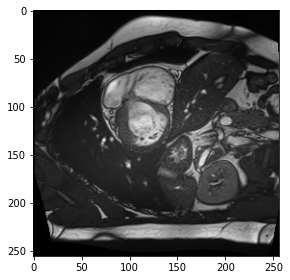

In [14]:
import nibabel as nib
import cv2 as cv
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np

data = nib.load(r'ACDC_training\patient025\patient025_4d.nii.gz')
data = data.get_fdata()
print(data.shape)

fig, ax = plt.subplots()
fig.tight_layout()
image_list = []
for i in range(data.shape[3]):
    image = cv.normalize(data[:, :, 0, i], None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F).astype(np.uint8)
    im = ax.imshow(image, cmap='gray', animated=True)
    image_list.append([im])

ani = animation.ArtistAnimation(fig, image_list, interval=500, blit=True, repeat_delay=1000)
HTML(ani.to_jshtml())

In [10]:
import nibabel as nib
import cv2 as cv
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np

data = nib.load(r'only_sfb\validation_raw\patient005_frame01.nii.gz')
data = data.get_fdata()
print(data.shape)

label = nib.load(r'only_sfb\gt_niftis\patient005_frame01.nii.gz')
label = label.get_fdata()
print(label.shape)

blended_list = []
for i in range(len(label.shape[2])):
    blended = cv.addWeighted(data[:, :, i], 0.5, label[:, :, i], 0.5, 0.0)
    blended_list.append(blended)
blended_list = np.stack(blended_list, axis=0)

fig, ax = plt.subplots()
fig.tight_layout()
image_list = []
for i in range(data.shape[3]):
    image = cv.normalize(data[:, :, 1, i], None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F).astype(np.uint8)
    im = ax.imshow(image, cmap='gray', animated=True)
    image_list.append([im])

ani = animation.ArtistAnimation(fig, image_list, interval=500, blit=True, repeat_delay=1000)
HTML(ani.to_jshtml())

(256, 216, 10)
(256, 216, 10)


IndexError: tuple index out of range

In [55]:
import torch
import torch.nn as nn

from einops import rearrange
from einops.layers.torch import Rearrange

#class RelativeAttention2D(nn.Module):
#    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, dropout=0.):
#        super().__init__()
#        inner_dim = dim_head * heads
#        project_out = not (heads == 1 and dim_head == inp)
#
#        self.ih, self.iw = image_size
#
#        self.heads = heads
#        self.scale = dim_head ** -0.5
#
#        # parameter table of relative position bias
#        self.relative_bias_table = nn.Parameter(
#            torch.zeros((2 * self.ih - 1) * (2 * self.iw - 1), heads))
#
#        coords = torch.meshgrid((torch.arange(self.ih), torch.arange(self.iw)))
#        coords = torch.flatten(torch.stack(coords), 1)
#        relative_coords = coords[:, :, None] - coords[:, None, :]
#
#        relative_coords[0] += self.ih - 1
#        relative_coords[1] += self.iw - 1
#        relative_coords[0] *= 2 * self.iw - 1 # 2d indices to 1d, need to multiply by width of image * 2
#        relative_coords = rearrange(relative_coords, 'c h w -> h w c')
#        relative_index = relative_coords.sum(-1).flatten().unsqueeze(1)
#        self.register_buffer("relative_index", relative_index)
#
#        self.attend = nn.Softmax(dim=-1)
#        self.to_qkv = nn.Linear(inp, inner_dim * 3, bias=False)
#
#        self.to_out = nn.Sequential(
#            nn.Linear(inner_dim, oup),
#            nn.Dropout(dropout)
#        ) if project_out else nn.Identity()
#
#    def forward(self, x):
#        # B, L, E
#        qkv = self.to_qkv(x).chunk(3, dim=-1)
#        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)
#
#        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
#
#        # Use "gather" for more efficiency on GPUs
#        relative_bias = self.relative_bias_table.gather(0, self.relative_index.repeat(1, self.heads))
#        relative_bias = rearrange(relative_bias, '(h w) c -> 1 c h w', h=self.ih*self.iw, w=self.ih*self.iw)
#        dots = dots + relative_bias
#
#        attn = self.attend(dots)
#        out = torch.matmul(attn, v)
#        out = rearrange(out, 'b h n d -> b n (h d)')
#        out = self.to_out(out)
#        return out

class RelativeAttention1D(nn.Module):
    def __init__(self, inp, oup, seq_length, heads=8, dim_head=32, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == inp)
        self.seq_length = seq_length

        self.heads = heads
        self.scale = dim_head ** -0.5

        # parameter table of relative position bias
        self.relative_bias_table = nn.Parameter(torch.zeros(2 * seq_length - 1, heads))

        coords = torch.arange(seq_length)
        coords = torch.stack(torch.meshgrid([coords]))
        coords = torch.flatten(coords, 1)
        relative_coords = coords[:, :, None] - coords[:, None, :]

        relative_coords[0] += seq_length - 1
        relative_coords = rearrange(relative_coords, 'c h w -> h w c')
        relative_index = relative_coords.sum(-1).flatten().unsqueeze(1)
        self.register_buffer("relative_index", relative_index)

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(inp, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, oup),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        # B, L, E
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        # Use "gather" for more efficiency on GPUs
        relative_bias = self.relative_bias_table.gather(0, self.relative_index.repeat(1, self.heads))
        relative_bias = rearrange(relative_bias, '(h w) c -> 1 c h w', h=self.seq_length, w=self.seq_length)
        dots = dots + relative_bias

        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out


class CrossRelativeAttention(nn.Module):
    def __init__(self, inp, oup, size_2d, size_1d, rescaled, heads, dim_head, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == inp)

        self.heads = heads
        self.scale = dim_head ** -0.5
        self.rescaled = rescaled

        self.ih = self.iw = size_2d
        # parameter table of relative position bias
        self.relative_bias_table_2d = nn.Parameter(torch.zeros((2 * self.ih - 1) * (2 * self.iw - 1), heads))

        coords_2d = torch.meshgrid((torch.arange(self.ih), torch.arange(self.iw)))
        coords_2d = torch.flatten(torch.stack(coords_2d), 1)
        relative_coords_2d = coords_2d[:, :, None] - coords_2d[:, None, :]

        relative_coords_2d[0] += self.ih - 1
        relative_coords_2d[1] += self.iw - 1
        relative_coords_2d[0] *= 2 * self.iw - 1
        relative_coords_2d = rearrange(relative_coords_2d, 'c h w -> h w c')
        relative_index_2d = relative_coords_2d.sum(-1).flatten().unsqueeze(1)
        self.register_buffer("relative_index_2d", relative_index_2d)

        # parameter table of relative position bias
        self.seq_length = size_1d
        self.relative_bias_table_1d = nn.Parameter(torch.zeros(2 * size_1d - 1, heads))

        coords_1d = torch.arange(size_1d)
        coords_1d = torch.stack(torch.meshgrid([coords_1d]))
        coords_1d = torch.flatten(coords_1d, 1)
        relative_coords_1d = coords_1d[:, :, None] - coords_1d[:, None, :]

        relative_coords_1d[0] += size_1d - 1
        relative_coords_1d = rearrange(relative_coords_1d, 'c h w -> h w c')
        relative_index_1d = relative_coords_1d.sum(-1).flatten().unsqueeze(1)
        self.register_buffer("relative_index_1d", relative_index_1d)

        self.attend = nn.Softmax(dim=-1)
        self.to_q = nn.Linear(inp, inner_dim, bias=False)
        self.to_k = nn.Linear(inp, inner_dim, bias=False)
        self.to_v = nn.Linear(inp, inner_dim, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, oup),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, query, key, value, attn_mask=None, key_padding_mask=None):
        # B, L, E
        q = self.to_q(query)
        k = self.to_k(key)
        v = self.to_v(value)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), [q, k, v])

        relative_bias_2d = self.relative_bias_table_2d.gather(0, self.relative_index_2d.repeat(1, self.heads))
        relative_bias_2d = rearrange(relative_bias_2d, '(h w) c -> 1 c h w', h=self.ih*self.iw, w=self.ih*self.iw)

        relative_bias_1d = self.relative_bias_table_1d.gather(0, self.relative_index_1d.repeat(1, self.heads))
        relative_bias_1d = rearrange(relative_bias_1d, '(h w) c -> 1 c h w', h=self.seq_length, w=self.seq_length)

        if self.rescaled == '1d':
            relative_bias_2d = torch.matmul(q.transpose(-1, -2), relative_bias_2d).transpose(-1, -2)
            relative_bias_1d = torch.matmul(k.transpose(-1, -2), relative_bias_1d).transpose(-1, -2)
            q = q + relative_bias_2d
            k = k + relative_bias_1d
            v = v + relative_bias_1d
        elif self.rescaled == '2d':
            relative_bias_1d = torch.matmul(q.transpose(-1, -2), relative_bias_1d).transpose(-1, -2)
            relative_bias_2d = torch.matmul(k.transpose(-1, -2), relative_bias_2d).transpose(-1, -2)
            q = q + relative_bias_1d
            k = k + relative_bias_2d
            v = v + relative_bias_2d

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out

attn = CrossRelativeAttention(256, 256, size_2d=28, size_1d=6, rescaled='1d', heads=8, dim_head=64)

q = torch.rand(size=(2, 28*28, 256))
v = k = torch.rand(size=(2, 6, 256))
attn(query=q, key=k, value=v)

tensor([[[ 0.3317,  0.0366,  0.0438,  ...,  0.0288, -0.0171,  0.1528],
         [ 0.3307,  0.0364,  0.0422,  ...,  0.0313, -0.0185,  0.1529],
         [ 0.3314,  0.0382,  0.0409,  ...,  0.0302, -0.0190,  0.1532],
         ...,
         [ 0.3318,  0.0369,  0.0410,  ...,  0.0293, -0.0176,  0.1535],
         [ 0.3303,  0.0368,  0.0407,  ...,  0.0284, -0.0180,  0.1509],
         [ 0.3307,  0.0381,  0.0394,  ...,  0.0283, -0.0163,  0.1529]],

        [[ 0.2844,  0.0067, -0.0265,  ..., -0.0060,  0.0160,  0.1786],
         [ 0.2853,  0.0084, -0.0265,  ..., -0.0039,  0.0147,  0.1771],
         [ 0.2835,  0.0074, -0.0267,  ..., -0.0030,  0.0156,  0.1778],
         ...,
         [ 0.2865,  0.0062, -0.0272,  ..., -0.0035,  0.0165,  0.1748],
         [ 0.2838,  0.0033, -0.0280,  ..., -0.0051,  0.0164,  0.1759],
         [ 0.2836,  0.0079, -0.0270,  ..., -0.0046,  0.0161,  0.1764]]],
       grad_fn=<AddBackward0>)

In [30]:
class Caca(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(10, 30)
    
    def forward(x):
        return x

class Caca2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(10, 10)
        self.layer2 = nn.Linear(10, 10)
        self.layer3 = nn.Linear(10, 10)
    
    def forward(x):
        return x

caca = Caca()
caca2 = Caca2()

nb_params =  sum(p.numel() for p in caca.parameters() if p.requires_grad)
nb_params2 =  sum(p.numel() for p in caca2.parameters() if p.requires_grad)

print(nb_params)
print(nb_params2)

330
330


In [15]:
def get_indices_1d(input_resolution):
    # get pair-wise relative position index for each token inside the window
    coords = torch.arange(input_resolution[0])
    coords_flatten = torch.stack(torch.meshgrid([coords]))
    relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww     i-i', j-j' [-(wh-1), wh-1]
    relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
    relative_coords[:, :, 0] += input_resolution[0] - 1  # shift to start from 0    i-i'+ h-1, j-j'+ w-1 [0, 2wh-2]
    relative_position_index = relative_coords.sum(-1)  # Wh, Ww  parameters weights are 1d [0, (2wh-1) * (2ww-1)]
    return relative_position_index

In [3]:
%matplotlib qt

import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import cv2
from monai.visualize.utils import blend_images
from matplotlib import cm
from tqdm import tqdm
import nibabel as nib
import cv2 as cv

def get_patient():
    path_list = glob(r'only_sfb\validation_raw\*gz', recursive=True)
    max_depth = 0
    max_path = 'caca'
    for path in path_list:
        data = nib.load(path)
        data = data.get_fdata()
        depth = data.shape[2]
        if depth >= max_depth:
            max_depth = depth
            max_path = path
    return max_path.split(os.sep)[-1][:-7]

name = get_patient()
print(name)

fourcc = cv2.VideoWriter_fourcc(*'MJPG')

pred = nib.load(r"only_sfb\validation_raw\\" + name + ".nii.gz")
pred = pred.get_fdata()
print(pred.shape)
pred = np.flipud(pred)

img = nib.load(r"out\nnUNet_raw_data_base\nnUNet_raw_data\Task027_ACDC\imagesTr\\" + name + "_0000.nii.gz")
img = img.get_fdata()
print(img.shape)

img = np.flipud(img)

img = np.transpose(img, (2, 0, 1))
out_arr = []
for i in range(len(img)):
    out = cv.normalize(img[i], None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX).astype(np.uint8)
    out = cv.cvtColor(out, cv.COLOR_GRAY2RGB)
    out_arr.append(out)
out_arr = np.stack(out_arr, axis=0)

patient_images = []
for i in range(pred.shape[-1]):
    current_seg = pred[:, :, i]
    current_img = img[:, :, i]
    for j in range(1, 4):
        seg = (current_seg == j).astype(np.uint8)
        contours, hierarchy = cv.findContours(seg, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        color = [0, 0, 0]
        color[j - 1] = 255
        cv.drawContours(out_arr[i], contours, -1, color, 1)

    #out = blend_images(x[None, :, :], seg[None, :, :], alpha=0.75, cmap=cm.hsv).transpose(1, 2, 0)
    #W, H, C = out.shape
    #out = cv2.normalize(out, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    #patient_images.append(out)

    #print(out.transpose(1, 2, 0).shape)
    #fig, ax = plt.subplots(1, 1)
    #ax.imshow(out.transpose(1, 2, 0))
    #plt.show()
    #plt.waitforbuttonpress()
    #plt.close(fig)

video_name = name + '.avi'
W, H = out_arr.shape[1], out_arr.shape[2]
video = cv2.VideoWriter(video_name, fourcc, 2, (H, W))

for i in range(len(out_arr)):
    video.write(cv2.cvtColor(out_arr[i], cv2.COLOR_RGB2BGR))

cv2.destroyAllWindows()
video.release()

patient043_frame07
(174, 224, 12)
(174, 224, 12)


In [83]:
%matplotlib qt

import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import cv2
from monai.visualize.utils import blend_images
from matplotlib import cm
from tqdm import tqdm

fourcc = cv2.VideoWriter_fourcc(*'MJPG')

name = "patient002_slice05"
print(name)

pred = nib.load(name + ".nii.gz")
pred = pred.get_fdata()
print(pred.shape)

img = nib.load(r"out\nnUNet_raw_data_base\nnUNet_raw_data\Task028_Lib\imagesTr\\" + name + "_0000.nii.gz")
img = img.get_fdata()
print(img.shape)

img = np.transpose(img, (2, 0, 1))
out_arr = []
for i in range(len(img)):
    out = cv.normalize(img[i], None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX).astype(np.uint8)
    out = cv.cvtColor(out, cv.COLOR_GRAY2RGB)
    out_arr.append(out)
out_arr = np.stack(out_arr, axis=0)

patient_images = []
for i in range(pred.shape[-1]):
    current_seg = pred[:, :, i]
    current_img = img[:, :, i]
    for j in range(1, 4):
        seg = (current_seg == j).astype(np.uint8)
        contours, hierarchy = cv.findContours(seg, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        color = [0, 0, 0]
        color[j - 1] = 255
        cv.drawContours(out_arr[i], contours, -1, color, 1)

    #out = blend_images(x[None, :, :], seg[None, :, :], alpha=0.75, cmap=cm.hsv).transpose(1, 2, 0)
    #W, H, C = out.shape
    #out = cv2.normalize(out, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    #patient_images.append(out)

    #print(out.transpose(1, 2, 0).shape)
    #fig, ax = plt.subplots(1, 1)
    #ax.imshow(out.transpose(1, 2, 0))
    #plt.show()
    #plt.waitforbuttonpress()
    #plt.close(fig)

video_name = name + '.avi'
W, H = out_arr.shape[1], out_arr.shape[2]
video = cv2.VideoWriter(video_name, fourcc, 6, (H, W))

for i in range(len(out_arr)):
    video.write(cv2.cvtColor(out_arr[i], cv2.COLOR_RGB2BGR))

cv2.destroyAllWindows()
video.release()

patient002_slice05
(512, 512, 40)
(512, 512, 40)


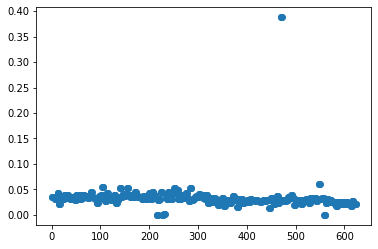

In [17]:
import pickle
from glob import glob
import matplotlib.pyplot as plt

res_t_list = []
for path in glob(r'data_ok_original/**/*.npz', recursive=True):
    data = np.load(path)
    res_t_list.append(data['resT'])

x = np.arange(len(res_t_list))
plt.scatter(x=x, y=res_t_list)

In [6]:
import numpy as np

data = np.load(r'data_ok_original\cholcoeur\Original\ID_._20150218_default_user_Slice_04.npz')
print(data.files)
print(data['image'].shape)
print(data['resT'])
print(data['resX'])
print(data['Pixel_shape'])

['image', 'label_img', 'Pixel_shape', 'resX', 'resY', 'resT', 'ImageSpacing', 'Number_Slice']
(25, 288, 288)
0.03160000038147
1.4375
[1.4375 1.4375]


In [5]:
from pathlib import Path
import shutil
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import nibabel as nib

def delete_if_exist(folder_name):
    dirpath = Path(folder_name)
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)

def fix_labels(label):
    label[label == 1] = 3
    label[label == 4] = 1
    return label

new_folder_name = 'custom_lib_t'

delete_if_exist(new_folder_name)

Path(new_folder_name).mkdir(parents=True, exist_ok=True)
folder_nb = 0

all_files = glob('data_ok_original/**/*.npz', recursive=True)
sorted_all_files = sorted(all_files)

past_name = ''
for patient in tqdm(sorted_all_files):

    data = np.load(patient)
    img = np.transpose(data['image'], (1, 2, 0))
    label = np.transpose(data['label_img'], (1, 2, 0))
    label = fix_labels(label)
    if np.any(~np.isin([1, 2, 3], np.unique(label))):
        with open(os.path.join(new_folder_name, 'failed_patients.cfg'), 'a') as fd:
            fd.write(patient + '\n')
        continue

    broken_string = patient.split('_Slice_')
    name = broken_string[0]
    if name != past_name:
        folder_nb += 1
        patient_string = ('patient' + str(folder_nb).zfill(3))
        patient_folder_name = os.path.join(new_folder_name, patient_string)
        delete_if_exist(patient_folder_name)
        Path(patient_folder_name).mkdir(parents=True, exist_ok=True)
    with open(os.path.join(patient_folder_name, 'info.cfg'), 'a') as fd:
        fd.write(patient + '\n')
    
    slice_nb = broken_string[-1].split('.')[0]
    img = nib.Nifti1Image(img, affine=np.eye(4))
    label = nib.Nifti1Image(label, affine=np.eye(4))
    res_t = max(1e-7, data['resT'])
    img.header['pixdim'] = [1.0, data['resY'], data['resX'], res_t, 1.0, 1.0, 1.0, 1.0]
    label.header['pixdim'] = [1.0, data['resY'], data['resX'], res_t, 1.0, 1.0, 1.0, 1.0]
    nib.save(img, os.path.join(patient_folder_name, patient_string + '_slice' + slice_nb + '.nii.gz'))  
    nib.save(label, os.path.join(patient_folder_name, patient_string + '_slice' + slice_nb + '_gt.nii.gz'))
    past_name = name

100%|██████████| 625/625 [06:26<00:00,  1.62it/s]


In [13]:
%matplotlib qt

import nibabel as nib
import matplotlib.pyplot as plt

data = nib.load(r'data_saud\3D\cineED\250001-001_ED\250001-001_ED_label.nii.gz')
arr = data.get_fdata()
print(arr.shape)

plt.imshow(arr[:, :, 5], cmap='gray')

data = nib.load(r'ACDC_training\patient001\patient001_frame01_gt.nii.gz')
arr = data.get_fdata()
print(arr.shape)

(288, 248, 13)
(216, 256, 10)


In [5]:
from pathlib import Path
from glob import glob
import shutil
import numpy as np
from tqdm import tqdm
import nibabel as nib

def get_metadata():
    data_dict = {}
    for path in glob(r'data_saud\2D\**\*.npz', recursive=True):
        patient_name = path.split('\\')[-1].split('_')[0]
        data = np.load(path)
        if patient_name not in data_dict:
            data_dict[patient_name] = {'strength': [], 'manufacturer': []}
        data_dict[patient_name]['strength'].append(data['strength'])
        data_dict[patient_name]['manufacturer'].append(data['manufacturer'])

    out_dict = data_dict.copy()
    for key in data_dict.keys():
        strength_list = data_dict[key]['strength']
        manufacturer_list = data_dict[key]['manufacturer']
        assert strength_list.count(strength_list[0]) == len(strength_list), print(key)
        assert manufacturer_list.count(manufacturer_list[0]) == len(manufacturer_list), print(key)
        out_dict[key]['strength'] = data_dict[key]['strength'][0]
        out_dict[key]['manufacturer'] = data_dict[key]['manufacturer'][0]
    return out_dict

def delete_if_exist(folder_name):
    dirpath = Path(folder_name)
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)

new_folder_name = 'custom_quorum'

delete_if_exist(new_folder_name)

Path(new_folder_name).mkdir(parents=True, exist_ok=True)
folder_nb = 0

ed_images = glob(r'data_saud\3D\cineED\**\*image.nii.gz', recursive=True)
ed_labels = glob(r'data_saud\3D\cineED\**\*label.nii.gz', recursive=True)
es_images = glob(r'data_saud\3D\cineES\**\*image.nii.gz', recursive=True)
es_labels = glob(r'data_saud\3D\cineES\**\*label.nii.gz', recursive=True)
ed_images = sorted(ed_images)
ed_labels = sorted(ed_labels)
es_images = sorted(es_images)
es_labels = sorted(es_labels)

info_dict = get_metadata()
assert len(info_dict) == len(ed_images)

for idx, (ed_img_path, es_img_path, ed_gt_path, es_gt_path) in enumerate(tqdm(zip(ed_images, es_images, ed_labels, es_labels), total=len(ed_images))):
    patient_name = ed_img_path.split('\\')[-1].split('_')[0]

    strength = str(info_dict[patient_name]['strength'])
    manufacturer = str(info_dict[patient_name]['manufacturer'])

    ed_img = nib.load(ed_img_path)
    es_img = nib.load(es_img_path)
    ed_gt = nib.load(ed_gt_path)
    es_gt = nib.load(es_gt_path)

    ed_header = ed_img.header.copy()
    es_header = es_img.header.copy()
    ed_gt_header = ed_gt.header.copy()
    es_gt_header = es_gt.header.copy()

    ed_affine = ed_img.affine.copy()
    es_affine = es_img.affine.copy()
    ed_gt_affine = ed_gt.affine.copy()
    es_gt_affine = es_gt.affine.copy()

    ed_img_arr = ed_img.get_fdata()
    es_img_arr = es_img.get_fdata()
    ed_gt_arr = ed_gt.get_fdata()
    es_gt_arr = es_gt.get_fdata()

    assert np.any(np.isin([1, 2], np.unique(ed_gt_arr))), print(ed_gt_path)
    assert np.any(np.isin([1, 2], np.unique(es_gt_arr))), print(es_gt_path)

    patient_string = ('patient' + str(idx + 1).zfill(3))
    patient_folder_name = os.path.join(new_folder_name, patient_string)
    delete_if_exist(patient_folder_name)
    Path(patient_folder_name).mkdir(parents=True, exist_ok=True)

    with open(os.path.join(patient_folder_name, 'info.cfg'), 'a') as fd:
        fd.writelines([ed_img_path, '\n', es_img_path, '\n', strength, '\n', manufacturer, '\n'])

    ed_img = nib.Nifti1Image(ed_img_arr, affine=ed_affine, header=ed_header)
    es_img = nib.Nifti1Image(es_img_arr, affine=es_affine, header=es_header)
    ed_gt = nib.Nifti1Image(ed_gt_arr, affine=ed_gt_affine, header=ed_gt_header)
    es_gt = nib.Nifti1Image(es_gt_arr, affine=es_gt_affine, header=es_gt_header)

    nib.save(ed_img, os.path.join(patient_folder_name, patient_string + '_ed.nii.gz'))  
    nib.save(ed_gt, os.path.join(patient_folder_name, patient_string + '_ed_gt.nii.gz'))

    nib.save(es_img, os.path.join(patient_folder_name, patient_string + '_es.nii.gz'))  
    nib.save(es_gt, os.path.join(patient_folder_name, patient_string + '_es_gt.nii.gz'))

100%|██████████| 192/192 [01:04<00:00,  3.00it/s]


In [28]:
data = nib.load(r'data_saud\3D\cineED\250001-001_ED\250001-001_ED_label.nii.gz')
arr = data.get_fdata()
print(arr.shape)
print(np.unique(arr))
print(np.any(np.isin([1., 2.], np.unique(arr))))

plt.imshow(arr[:, :, 5], cmap='gray')

(288, 248, 13)
[0. 1. 2.]
True


In [11]:
from glob import glob
import nibabel as nib
import numpy as np
from tqdm import tqdm

nb_slices_list = []
res_t_list = []
path_list = glob(r'ACDC_training/**/*4d*', recursive=True)
for path in tqdm(path_list):
    data = nib.load(path)
    res_t = data.header.get_zooms()[-1]
    res_t_list.append(res_t)
    arr = data.get_fdata()
    nb_slices_list.append(arr.shape[3])

nb_slices_list = np.array(nb_slices_list)
res_t_list = np.array(res_t_list)
print(nb_slices_list.min())
print(nb_slices_list.max())

print(res_t_list.min())
print(res_t_list.max())


100%|██████████| 100/100 [00:20<00:00,  4.90it/s]

12
35
1.0
1.0


In [16]:
from glob import glob
import nibabel as nib
import numpy as np
from tqdm import tqdm

nb_slices_list = []
res_t_list = []
path_list = glob(r'custom_lib_t/**/*.gz', recursive=True)
for path in tqdm(path_list):
    data = nib.load(path)
    res_t = data.header.get_zooms()[2]
    res_t_list.append(res_t)
    arr = data.get_fdata()
    nb_slices_list.append(arr.shape[2])

nb_slices_list = np.array(nb_slices_list)
res_t_list = np.array(res_t_list)
print(nb_slices_list.min())
print(nb_slices_list.max())

print(res_t_list.min())
print(res_t_list.max())


100%|██████████| 1240/1240 [02:04<00:00,  9.96it/s]

22
80
1e-07
0.388


In [1]:
import pickle

with open(r'out\nnUNet_preprocessed\Task028_Lib\custom_experiment_planner_stage0\patient001_slice05.pkl', 'rb') as fd:
    print(pickle.load(fd))

OrderedDict([('original_size_of_raw_data', array([ 40, 512, 512])), ('original_spacing', array([0.023, 0.625, 0.625])), ('list_of_data_files', ['C:\\Users\\Portal\\Documents\\Isensee\\nnUNet\\nnunet\\out\\nnUNet_raw_data_base\\nnUNet_raw_data\\Task028_Lib\\imagesTr\\patient001_slice05_0000.nii.gz']), ('seg_file', 'C:\\Users\\Portal\\Documents\\Isensee\\nnUNet\\nnunet\\out\\nnUNet_raw_data_base\\nnUNet_raw_data\\Task028_Lib\\labelsTr\\patient001_slice05.nii.gz'), ('itk_origin', (0.0, 0.0, 0.0)), ('itk_spacing', (0.625, 0.625, 0.023000000044703484)), ('itk_direction', (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)), ('original_path', 'data_ok_original\\RACINE\\Original\\RACINE_AJ04069_20141203_Slice_05.npz'), ('crop_bbox', [[0, 40], [0, 507], [21, 492]]), ('classes', array([-1.,  0.,  1.,  2.,  3.], dtype=float32)), ('size_after_cropping', (40, 507, 471)), ('use_nonzero_mask_for_norm', OrderedDict([(0, False)])), ('size_after_resampling', (40, 240, 223)), ('spacing_after_resampling', ar

In [ ]:
import nibabel as nib

a = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task027_ACDC\labelsTr\patient001_frame12.nii.gz')
a = a.get_fdata()
sample = a[:, :, ]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load(r'out\nnUNet_raw_data_base\nnUNet_cropped_data\Task026_M&Ms\A4J4S4_frame14_u.npz')
print(data['data'].shape)

plt.imshow(data['data'][0, 4, :, :], cmap='gray')

In [ ]:
%matplotlib qt

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

for path in glob(r'out\nnUNet_preprocessed\Task026_MMs\gt_segmentations\*'):
    img = nib.load(path)
    img = img.get_fdata()
    assert np.count_nonzero(img > 0) > 0

#plt.imshow(img[:, :, 8], cmap='gray')

In [ ]:
data = np.load('C:\\data_jonas\\RACINE\\Original\\RACINE_AJ04069_20141203_Slice_05.npz')
label = np.transpose(data['label_img'], (1, 2, 0))
plt.imshow(label[:, :, 0], cmap='gray')

In [ ]:
import torch

t1 = torch.rand(1, 3, 4)
t2 = torch.rand(1, 3, 3)
out = torch.matmul(t2, t1)
print(out.shape)

In [ ]:
import pickle

with open(r'splits_final.pkl', 'rb') as fd:
    d = pickle.load(fd)
    print(len(d[0]['val']))
    print(d)

In [ ]:
import torch

x = torch.rand(size=(2, 384, 28, 28))
x = torch.flatten(x, start_dim=2)
norm = torch.linalg.norm(x, dim=2, keepdim=True)
x = x / torch.max(norm, torch.tensor([1e-8], device=x.device))
out = torch.transpose(x, dim0=1, dim1=2)
print(out.shape)

In [ ]:
x = torch.rand(size=(2, 384, 28, 28))

x = torch.flatten(x, start_dim=2)
norm = torch.linalg.norm(x, dim=2, keepdim=True)
x = x / torch.max(norm, torch.tensor([1e-8], device=x.device))
x = torch.matmul(x, torch.transpose(x, dim0=1, dim1=2))
print(x.shape)

In [ ]:
x = torch.tensor([[0, 1, 2], [2, 1, 0]])
x = x.float()
means = x.mean(dim=1).unsqueeze(-1)
print(x.shape)
print(means.shape)
out = (x - means).unsqueeze(0)
norm = torch.linalg.norm(out, dim=2, keepdim=True)
out = out / torch.max(norm, torch.tensor([1e-8], device=x.device))
out = torch.matmul(out, torch.transpose(out, dim0=1, dim1=2))
print(out.shape)
print(out)

In [ ]:
x = torch.tensor([[0, 2], [1, 1], [2, 0]]).T
print(torch.cov(x))
x = x.float()
means = x.mean(dim=1).unsqueeze(-1)
print(x.shape)
print(means.shape)
out = (x - means).unsqueeze(0)
out = torch.matmul(out, torch.transpose(out, dim0=1, dim1=2)) / 2
print(out.shape)
print(out)

In [ ]:
%matplotlib qt

from glob import glob
import nibabel as nib
import torch
from torchvision.transforms.functional import center_crop
import matplotlib.pyplot as plt
from tqdm import tqdm

for data in tqdm(glob(r'out\nnUNet_preprocessed\Task027_ACDC\gt_segmentations\*.gz', recursive=True)):
    data = nib.load(data)
    arr = data.get_fdata()
    for i in range(arr.shape[-1]):
        payload = torch.from_numpy(arr[:, :, i])
        payload = center_crop(payload, 224)
        top = payload[0]
        bottom = payload[-1]
        left = payload[:, 0]
        right = payload[:, -1]
        if torch.count_nonzero(top) > 0 or torch.count_nonzero(bottom) > 0 or torch.count_nonzero(left) > 0 or torch.count_nonzero(right) > 0:
            fig, ax = plt.subplots(1, 1)
            ax.imshow(payload, cmap='gray')
            plt.show()
            plt.waitforbuttonpress()
            plt.close(fig)

In [ ]:
%matplotlib qt

from glob import glob
import nibabel as nib
import torch
from torchvision.transforms.functional import center_crop
import matplotlib.pyplot as plt
from tqdm import tqdm

for path in tqdm(glob(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task026_MMs\labelsTr\*.gz', recursive=True)):
    data = nib.load(path)
    arr = data.get_fdata()
    idx = arr.shape[-1] // 2
    fig, ax = plt.subplots(1, 1)
    print(path)
    ax.imshow(arr[:, :, idx], cmap='gray')
    plt.show()
    plt.waitforbuttonpress()
    plt.close(fig)

In [ ]:
%matplotlib qt

from glob import glob
import nibabel as nib
import torch
from torchvision.transforms.functional import center_crop
import matplotlib.pyplot as plt
from tqdm import tqdm

data = nib.load(r'out\nnUNet_preprocessed\Task027_ACDC\gt_segmentations\patient001_frame01.nii.gz')
arr = data.get_fdata()
idx = arr.shape[-1] // 2
idx2 = arr.shape[-1] - 1
fig, ax = plt.subplots(1, 2)
ax[0].imshow(arr[:, :, idx], cmap='gray')
ax[1].imshow(arr[:, :, idx2], cmap='gray')
plt.show()
plt.waitforbuttonpress()
plt.close(fig)

In [ ]:
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
import cv2

a = np.zeros(shape=(224, 224))
p1 = (112, 112)
p2 = (160, 160)
a[p1[0], p1[1]] = 1
a[p2[0], p2[1]] = 1
cv2.line(a, p1, p2, 1, thickness=3, lineType=8)
#blurred = cv2.GaussianBlur(a, (51, 51), sigmaX=0)
blurred = gaussian_filter(a, sigma=11)
fig, ax = plt.subplots(1, 1)
ax.imshow(blurred, cmap='plasma')
plt.show()

In [64]:
%matplotlib qt

import nibabel as nib
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

max_m = 0
for path in glob(r'out\nnUNet_preprocessed\Task027_ACDC\gt_segmentations\*.gz'):
    data = nib.load(path)
    arr = data.get_fdata()
    if arr.shape[-1] > max_m:
        max_m = arr.shape[-1]

print(max_m)

s = np.zeros(shape=(max_m,))
l_global = []
for path in tqdm(glob(r'out\nnUNet_preprocessed\Task027_ACDC\gt_segmentations\*.gz')):
    data = nib.load(path)
    arr = data.get_fdata()
    arr = np.reshape(arr, newshape=(-1, arr.shape[-1]))
    #unique_list = []
    l = []
    for i in range(arr.shape[-1]):
        c = (np.count_nonzero(arr[:, i] == 1) + np.count_nonzero(arr[:, i] == 2) + np.count_nonzero(arr[:, i] == 3)) / arr[:, i].size
        l.append(c)
        #un = len(np.unique(arr[:, i])) - 1
        #unique_list.append(un)
    xvals = np.linspace(0, 100, num=max_m)
    x = np.linspace(0, 100, num=len(l))
    l = np.interp(xvals, xp=x, fp=l)
    l_global.append(l)

out = np.stack(l_global, axis=0)
out = out.mean(axis=0)

print(np.argmax(out))
print(np.argsort(out))
print(out)
x = np.arange(len(out))
plt.bar(x, height=out)
plt.show()

18


100%|██████████| 200/200 [00:01<00:00, 169.58it/s]

4
[17 16 15 14 13 12 11 10  0  9  8  1  7  6  2  5  3  4]
[0.04094214 0.04762606 0.05419212 0.05585726 0.05596549 0.05448385
 0.05200067 0.04898229 0.04554894 0.04191604 0.03810533 0.03418236
 0.03009183 0.02598536 0.0217128  0.01724831 0.01228033 0.00718482]


0.6875


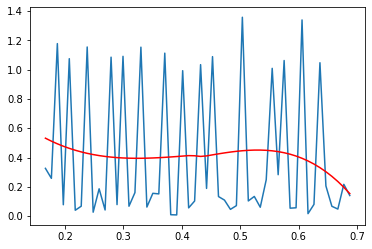

In [27]:
from torch import tensor
from scipy.signal import savgol_filter
import numpy as np
import matplotlib.pyplot as plt
from copy import copy

d = {0.3333333333333333: tensor(1.1544), 0.6363636363636364: tensor(0.2079), 0.6: tensor(1.3401), 0.375: tensor(1.1136), 0.5: tensor(1.3585), 0.46153846153846156: tensor(0.1114), 0.25: tensor(1.1556), 0.3125: tensor(0.1625), 0.42857142857142855: tensor(1.0352), 0.4: tensor(0.9940), 0.625: tensor(1.0483), 0.3: tensor(1.0919), 0.2857142857142857: tensor(1.0862), 0.2222222222222222: tensor(1.0759), 0.2: tensor(1.1787), 0.6666666666666666: tensor(0.2189), 0.5625: tensor(0.2846), 0.5555555555555556: tensor(1.0100), 0.2727272727272727: tensor(0.1884), 0.5714285714285714: tensor(1.0634), 0.18181818181818182: tensor(0.2598), 0.36363636363636365: tensor(0.1537), 0.4444444444444444: tensor(1.0899), 0.4375: tensor(0.1911), 0.5294117647058824: tensor(0.1057), 0.29411764705882354: tensor(0.0806), 0.21428571428571427: tensor(0.0797), 0.5454545454545454: tensor(0.2504), 0.23529411764705882: 
tensor(0.0697), 0.4117647058823529: tensor(0.0584), 0.16666666666666666: tensor(0.3279), 0.35294117647058826: tensor(0.0639), 0.6153846153846154: tensor(0.0822), 0.47058823529411764: tensor(0.0736), 0.6875: tensor(0.1425), 0.4166666666666667: tensor(0.1050), 0.35714285714285715: tensor(0.1576), 0.45454545454545453: tensor(0.1356), 0.6428571428571429: tensor(0.0692), 0.5384615384615384: tensor(0.0627), 0.23076923076923078: tensor(0.0421), 0.6470588235294118: tensor(0.0502), 0.5833333333333334: tensor(0.0563), 0.5333333333333333: tensor(0.1363), 0.2777777777777778: tensor(0.0440), 0.3076923076923077: tensor(0.0696), 0.5882352941176471: tensor(0.0589), 0.4666666666666667: tensor(0.0482), 0.26666666666666666: tensor(0.0289), 0.38461538461538464: tensor(0.0116), 0.3888888888888889: tensor(0.0103), 0.6111111111111112: tensor(0.0189)}

d = dict(sorted(d.items()))
d2 = copy(d)
out = savgol_filter(list(d.values()), 50, 3)

for k, v in zip(d.keys(), out): # window size 20, polynomial order 3
    d[k] = v

print(min(d, key= lambda x: d[x]))

x = np.linspace(min(list(d.keys())), max(list(d.keys())), len(list(d.values())))

plt.plot(x, list(d2.values()))
plt.plot(x,out, color='red')
plt.show()

In [89]:
%matplotlib qt

import cv2 as cv
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

def get_distance_image2(label1, label2, norm):

        h, w = label1.shape

        accumulation = np.zeros((2, h, w), dtype=np.float32)
        for t in range(1, 4):
            current_class1 = (label1 == t).astype(int)
            current_class2 = (label2 == t).astype(int)
            outer_mask = np.logical_or(current_class1, current_class2)
            current_class = current_class1 - current_class2
            #plt.imshow(current_class1 - current_class2, cmap='gray')
            current_class[current_class < 0] = 0
            current_class[outer_mask == 0] = 1

            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(current_class, cmap='gray')
            ax[1].imshow(np.logical_not(current_class), cmap='gray')
            plt.waitforbuttonpress()
            plt.close(fig)

            dst, labels = cv.distanceTransformWithLabels(current_class.astype(np.uint8), cv.DIST_L2, cv.DIST_MASK_PRECISE, labelType=cv.DIST_LABEL_PIXEL)

            fig, ax = plt.subplots(1, 1)
            ax.imshow(labels, cmap='gray')
            plt.waitforbuttonpress()
            plt.close(fig)

            
            # labels is a LABEL map indicating LABEL (not index) of nearest zero pixel. Zero pixels have different labels.
            #  As a result som labels in backgound and in heart structure can have the same label.

            #fig, ax = plt.subplots(1, 1)
            #ax.imshow(index, cmap='gray')

            place = np.argwhere(current_class == 0) # get coords of background pixels
            nearCord = place[labels-1,:] # get coords of nearest zero pixel of EVERY pixels of the image. For background this is current coords.

            nearPixel = np.transpose(nearCord, axes=(2, 0, 1))

            grid = np.indices(current_class.shape).astype(float)

            diff = grid - nearPixel
            diff[0][outer_mask == 0] = 0
            diff[1][outer_mask == 0] = 0
            diff[0][current_class == 0] = 0
            diff[1][current_class == 0] = 0

            if norm:
                dr = np.sqrt(np.sum(diff**2, axis = 0))
            else:
                dr = np.ones_like(current_class1)

            #nearpixeltoshow2 = np.copy(nearPixel2)
            #nearpixeltoshow2[0][current_class2 == 0] = 0
            #nearpixeltoshow2[0][current_class2 == 0] = 0

            fig, ax = plt.subplots(1, 6)
            ax[0].imshow(current_class1, cmap='gray')
            ax[1].imshow(current_class2, cmap='gray')
            ax[2].imshow(outer_mask, cmap='gray')
            ax[3].imshow(current_class, cmap='gray')
            ax[4].imshow(nearPixel[0], cmap='gray')
            ax[5].imshow(diff[0], cmap='gray')
            plt.show()
            plt.waitforbuttonpress()
            plt.close(fig)

            #direction = np.zeros((2, h, w), dtype=np.float32)
            #direction[0, current_class>0] = np.divide(diff[0, current_class>0], dr[current_class>0])
            #direction[1, current_class>0] = np.divide(diff[1, current_class>0], dr[current_class>0])
#
            #accumulation[:, current_class>0] = 0
            #accumulation = accumulation + direction

        #assert accumulation.max() <= 1.0 and accumulation.min() >= -1.0
        #return accumulation

def get_distance_image(label, norm):

        h, w = label.shape

        accumulation = np.zeros((2, h, w), dtype=np.float32)
        for t in range(1, 4):
            current_class = (label == t).astype(np.uint8)
            dst, labels = cv.distanceTransformWithLabels(current_class, cv.DIST_L2, cv.DIST_MASK_PRECISE, labelType=cv.DIST_LABEL_PIXEL)
            
            # labels is a LABEL map indicating LABEL (not index) of nearest zero pixel. Zero pixels have different labels.
            #  As a result som labels in backgound and in heart structure can have the same label.
            index = np.copy(labels)
            index[current_class > 0] = 0

            #fig, ax = plt.subplots(1, 1)
            #ax.imshow(index, cmap='gray')

            place = np.argwhere(index > 0) # get coords of background pixels
            nearCord = place[labels-1,:] # get coords of nearest zero pixel of EVERY pixels of the image. For background this is current coords.

            fig, ax = plt.subplots(1, 1)
            ax.imshow(nearCord[:, :, 0], cmap='gray')

            nearPixel = np.transpose(nearCord, axes=(2, 0, 1))
            grid = np.indices(current_class.shape).astype(float)

            diff = grid - nearPixel

            fig, ax = plt.subplots(1, 1)
            ax.imshow(diff[0, :, :], cmap='gray')

            if norm:
                dr = np.sqrt(np.sum(diff**2, axis = 0))
            else:
                dr = np.ones_like(current_class)

            direction = np.zeros((2, h, w), dtype=np.float32)
            direction[0, current_class>0] = np.divide(diff[0, current_class>0], dr[current_class>0])
            direction[1, current_class>0] = np.divide(diff[1, current_class>0], dr[current_class>0])

            accumulation[:, current_class>0] = 0
            accumulation = accumulation + direction

            #fig, ax = plt.subplots(1, 5)
            #ax[0].imshow(labels, cmap='gray')
            #ax[1].imshow(index, cmap='gray')
            #ax[2].imshow(nearPixel[0], cmap='gray')
            #ax[3].imshow(diff[0], cmap='gray')
            #ax[4].imshow(accumulation[0], cmap='gray')
            #plt.show()
            #plt.waitforbuttonpress()
            #plt.close(fig)

        assert accumulation.max() <= 1.0 and accumulation.min() >= -1.0
        return accumulation

data = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task027_ACDC\labelsTr\patient001_frame01.nii.gz')
arr = data.get_fdata()
get_distance_image2(arr[:, :, 2], arr[:, :, -2], norm=True)

KeyboardInterrupt: 

In [11]:
%matplotlib qt

from regex import D
from scipy.ndimage import distance_transform_edt as eucl_distance
import nibabel as nib

data = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task027_ACDC\labelsTr\patient009_frame01.nii.gz')
arr = data.get_fdata()

label1 = arr[:, :, 5]
label2 = arr[:, :, 5]
for t in range(0, 4):
    current_class1 = (label1 == t)
    current_class2 = (label2 == t)
    both_x = np.logical_xor(current_class1, current_class2)

    negmask = ~both_x
    d2 = eucl_distance(negmask) * negmask - (eucl_distance(both_x) - 1) * both_x

    fig, ax = plt.subplots(3, 2)
    ax[0, 0].imshow(eucl_distance(negmask), cmap='plasma')
    ax[0, 1].imshow(d2, cmap='plasma')
    ax[1, 0].imshow(negmask, cmap='plasma')
    ax[1, 1].imshow(both_x, cmap='plasma')
    ax[2, 0].imshow(current_class1, cmap='gray')
    ax[2, 1].imshow(current_class2, cmap='gray')
    plt.waitforbuttonpress()
    plt.close(fig)


KeyboardInterrupt: 

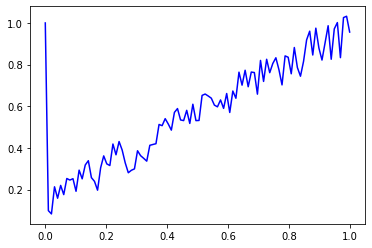

[0.56036945]


In [47]:
def ema(x, alpha):
    if len(x) < 2:
        return x
    return alpha * x[0] + (1 - alpha) * ema(x[1:], alpha)

x = np.linspace(0, 1, 100)
y = np.sin(x) + np.random.random(100) * 0.2

y[0] = 1

plt.plot(x,y, color='blue')
plt.show()

print(ema(y, 0.5))

for i in range(len(y)):
    ema(y[:i+1], 0.9)

In [104]:
d = {1: 2, 2: 3, 3: 4}
print(list(d.keys()))

[1, 2, 3]


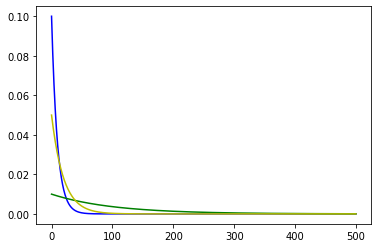

In [5]:
import numpy as np
import matplotlib.pyplot as plt

k = np.arange(0, 500)

out1 = 0.1 * (1 - 0.1)**k
out2 = 0.05 * (1 - 0.05)**k
out4 = 0.01 * (1 - 0.01)**k

x = np.linspace(0, 500, 500)
plt.plot(x, out1, color='blue')
#plt.plot(x, out2, color='red')
plt.plot(x, out4, color='green')
plt.plot(x, out2, color='y')
plt.show()

In [59]:
import matplotlib.pyplot as plt
from torch import tensor
from scipy.signal import savgol_filter
from copy import copy

sorted_past_percent = {0.16666666666666666: tensor(1.3600), 0.18181818181818182: tensor(1.8635), 0.2: tensor(1.2755), 0.21428571428571427: tensor(1.2107), 0.2222222222222222: tensor(1.1766), 0.23076923076923078: tensor(1.3838), 0.23529411764705882: tensor(0.9441), 0.25: tensor(1.2574), 0.26666666666666666: tensor(0.7934), 0.2727272727272727: tensor(1.4807), 0.2777777777777778: tensor(0.8594), 0.2857142857142857: tensor(1.2444), 0.29411764705882354: tensor(0.8864), 0.3: tensor(1.4371), 0.3076923076923077: tensor(0.8846), 0.3125: tensor(1.3526), 0.3333333333333333: tensor(1.2939), 0.35294117647058826: tensor(1.1473), 0.35714285714285715: tensor(1.4043), 0.36363636363636365: tensor(1.4904), 0.375: tensor(1.4065), 0.38461538461538464: tensor(0.4982), 0.3888888888888889: tensor(0.5812), 0.4: tensor(1.3152), 0.4117647058823529: tensor(0.9062), 0.4166666666666667: tensor(0.9554), 0.42857142857142855: 
tensor(1.3833), 0.4375: tensor(1.7965), 0.4444444444444444: tensor(1.2466), 0.45454545454545453: tensor(1.3580), 0.46153846153846156: tensor(1.3141), 0.4666666666666667: tensor(0.8624), 0.47058823529411764: tensor(1.1150), 0.5: tensor(1.2459), 0.5294117647058824: tensor(1.0637), 0.5333333333333333: tensor(1.4058), 0.5384615384615384: tensor(1.0728), 0.5454545454545454: tensor(1.6017), 0.5555555555555556: tensor(1.3091), 0.5625: tensor(1.5785), 0.5714285714285714: tensor(1.3401), 0.5833333333333334: tensor(0.7572), 0.5882352941176471: tensor(0.5408), 0.6: tensor(1.6448), 0.6111111111111112: tensor(0.5751), 0.6153846153846154: tensor(1.0880), 0.625: tensor(1.4969), 0.6363636363636364: tensor(1.4138), 
0.6428571428571429: tensor(1.0688), 0.6470588235294118: tensor(0.7755), 0.6666666666666666: tensor(1.5928), 0.6875: tensor(1.5619)}

print(len(sorted_past_percent))

#smooth1 = savgol_filter(list(sorted_past_percent.values()), 40, 3)
#smooth2 = savgol_filter(list(sorted_past_percent.values()), 50, 3)
smooth3 = savgol_filter(list(sorted_past_percent.values()), len(sorted_past_percent), 3)

new_d = copy(sorted_past_percent)
for k, v in zip(new_d.keys(), smooth3): # window size 50, polynomial order 3
    sorted_past_percent[k] = v

percent = min(new_d, key= lambda x: new_d[x])
print(percent)

plt.scatter(list(sorted_past_percent.keys()), list(new_d.values()))
#plt.plot(list(sorted_past_percent.keys()), smooth1, color='red')
#plt.plot(list(sorted_past_percent.keys()), smooth2, color='green')
plt.plot(list(sorted_past_percent.keys()), smooth3, color='y')
plt.show()

52
0.38461538461538464


In [7]:
t1 = torch.tensor([[1, 2], [3, 4]])
t2 = torch.tensor([[1, 2], [3, 4]])
print(t1.shape)

torch.matmul(t1, torch.transpose(t2, dim0=0, dim1=1))

torch.Size([2, 2])


tensor([[ 5, 11],
        [11, 25]])

In [ ]:
import torch.nn as nn
import torch
import matplotlib.pyplot as plt

from lib.position_embedding import PositionEmbeddingSine2d

def get_emb(sin_inp):
    """
    Gets a base embedding for one dimension with sin and cos intertwined
    """
    emb = torch.stack((sin_inp.sin(), sin_inp.cos()), dim=-1)
    return torch.flatten(emb, -2, -1)

class PositionalEncoding2D(nn.Module):
    def __init__(self, channels):
        """
        :param channels: The last dimension of the tensor you want to apply pos emb to.
        """
        super(PositionalEncoding2D, self).__init__()
        self.org_channels = channels
        channels = int(np.ceil(channels / 4) * 2)
        self.channels = channels
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2).float() / channels))
        self.register_buffer("inv_freq", inv_freq)
        self.cached_penc = None

    def forward(self, tensor):
        """
        :param tensor: A 4d tensor of size (batch_size, x, y, ch)
        :return: Positional Encoding Matrix of size (batch_size, x, y, ch)
        """
        if len(tensor.shape) != 4:
            raise RuntimeError("The input tensor has to be 4d!")

        if self.cached_penc is not None and self.cached_penc.shape == tensor.shape:
            return self.cached_penc

        self.cached_penc = None
        batch_size, x, y, orig_ch = tensor.shape
        pos_x = torch.arange(x, device=tensor.device).type(self.inv_freq.type())
        pos_y = torch.arange(y, device=tensor.device).type(self.inv_freq.type())
        sin_inp_x = torch.einsum("i,j->ij", pos_x, self.inv_freq)
        sin_inp_y = torch.einsum("i,j->ij", pos_y, self.inv_freq)
        emb_x = get_emb(sin_inp_x).unsqueeze(1)
        emb_y = get_emb(sin_inp_y)
        emb = torch.zeros((x, y, self.channels * 2), device=tensor.device).type(
            tensor.type()
        )
        emb[:, :, : self.channels] = emb_x
        emb[:, :, self.channels : 2 * self.channels] = emb_y

        self.cached_penc = emb[None, :, :, :orig_ch].repeat(tensor.shape[0], 1, 1, 1)
        return self.cached_penc

t = torch.rand(size=(2, 28, 28, 256))
obj = PositionalEncoding2D(256)
out = torch.flatten(obj(t).permute(0, 3, 1, 2), start_dim=2)
print(out.shape)

p_obj = PositionEmbeddingSine2d(num_pos_feats=128, normalize=False)
out2 = torch.flatten(p_obj(shape_util=(2, 28, 28), device='cpu'), start_dim=2)
print(out2.shape)

equal = out == out2

fig, ax = plt.subplots(1, 3)
ax[0].imshow(out.cpu()[0], cmap='plasma')
ax[1].imshow(out2.cpu()[0], cmap='plasma')
ax[2].imshow(equal.cpu()[0], cmap='plasma')
plt.show()

In [ ]:
t1 = torch.rand(size=(8, 256))
t2 = torch.rand(size=(8, 256))

out = torch.matmul(t1, torch.transpose(t2, dim0=0, dim1=1))
print(out.shape)

In [ ]:
import torch
from lib.loss import DistanceLoss

loss = DistanceLoss(1.0)
t1 = torch.rand(size=(8, 256, 1))
t2 = torch.rand(size=(8, 256, 1))

loss(t1, t2)

In [ ]:
t = torch.rand(size=(8, 8))
out = torch.tril(t).fill_diagonal_(0)
print(out)

In [5]:
import torch
from lib.loss import RelationLoss

loss_obj = RelationLoss()
batch1 = torch.rand(size=(2, 4, 224, 224))
batch2 = torch.rand(size=(2, 4, 224, 224))
loss_obj(batch1, batch2)

tensor(8.9118e-06)

In [ ]:
import SimpleITK as sitk
import nibabel as nib

path = 'out\\nnUNet_raw_data_base\\nnUNet_raw_data\\Task027_ACDC\\imagesTr\\patient094_frame01_0000.nii.gz'
data = sitk.ReadImage(path)
print(data[0].GetSpacing())
print(data[0].GetOrigin())
print(data[0].GetDirection())

n2_img = nib.load(path)
print(n2_img.shape)
print(n2_img.header)

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
from copy import copy

nib_img = nib.load('ACDC_training\\patient001\\patient001_4d.nii.gz')
img = nib_img.get_fdata()
nib_img2 = nib.load('ACDC_training\\patient001\\patient001_frame01.nii.gz')
img2 = nib_img2.get_fdata()
for key, value in nib_img.header.items():
    nib_img2.header[key] = value

print(img.shape)
print(img2.shape)
print(np.all(img2[:, :, 5] == img[:, :, 5, 0]))
print(np.all(img2[:, :, 5] == img[:, :, 5, 1]))
fig, ax = plt.subplots(1, 3)
ax[0].imshow(img[:, :, 5, 1], cmap='gray')
ax[1].imshow(img[:, :, 5, 0], cmap='gray')
ax[2].imshow(img2[:, :, 5], cmap='gray')

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt

img = nib.load('out\\nnUNet_raw_data_base\\nnUNet_raw_data\\Task027_ACDC\\imagesUn\\patient030_frame04_0000.nii.gz')
print(img.header)

In [ ]:
import numpy as np

data = np.load(r'out\nnUNet_raw_data_base\nnUNet_cropped_data\Task027_ACDC\unlabeled\patient001_frame02.npz')
print(data['data'].shape)

In [ ]:
import pickle

def load_pickle(file: str, mode: str = 'rb'):
    with open(file, mode) as f:
        a = pickle.load(f)
    return a

data = load_pickle(r'out\nnUNet_preprocessed\Task027_ACDC\dataset_properties.pkl')
print(data)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def rand_bbox(size):
    B = size[0]
    W = size[2]
    H = size[3]

    lam = np.random.beta(1, 1, size=(B,))

    cut_rat = np.sqrt(1. - lam)
    cut_w = (W * cut_rat).astype(np.int32)
    cut_h = (H * cut_rat).astype(np.int32)

    # uniform
    cx = np.random.randint(W, size=(B,))
    cy = np.random.randint(H, size=(B,))

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

bbx1, bby1, bbx2, bby2 = rand_bbox(size=(5, 1, 224, 224))
t = torch.rand(size=(5, 1, 224, 224))
for i in range(len(bbx1)):
    t[i, :, bbx1[i]:bbx2[i], bby1[i]:bby2[i]] = 0

fig, ax = plt.subplots(1, 5)
for j in range(5):
    ax[j].imshow(t[j, 0], cmap='gray')
plt.show()

In [ ]:
import torch

t = torch.randn(10)
t > 0.5